# Extract the Bounding Boxes from Person Masks for Supervisely Persons Data

The JSON annotation files for each image in the Supervisely Persons dataset does not contain bounding box information (specifically $x_{min}$, $x_{max}$, $y_{min}$ and $y_{max}$). These are required for the TensorFlow Object Detection API and therefore need to be extracted when creating the TFRecords. This notebook explores how to do this.

## Import Libraries

In [58]:
import sys
import json
import zlib
import base64
import numpy as np
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt

print(f'Python version: {sys.version.split()[0]}')
print(f'Numpy version: {np.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'OpenCV version: {cv.__version__}')

Python version: 3.6.8
Numpy version: 1.16.2
Matplotlib version: 3.0.2
OpenCV version: 4.0.1


## 1. Open an Annotation File

In [59]:
DATASET_PATH = '/media/adam/HDD Storage/Datasets/supervisely-persons/' # Path to the dataset root
FILE_PATH = 'ds1/ann/brothers-family-siblings-boys-50692.json' # Path from the dataset root to the desired file

In [64]:
with open(DATASET_PATH + FILE_PATH, 'r') as f:
    annotations_dict = json.load(f)

## 2. Convert Serialised Mask to Mask

The following functions are provided by Supervisely ([here](https://docs.supervise.ly/ann_format/)) to convert between serialised masks and masks.

In [61]:
def base64_2_mask(s):
    """
    Convert from a base64 encoded string to numpy mask.
    """
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    
    return mask

def mask_2_base64(mask):
    """
    Convert from a numpy mask to a base64 encoded string.
    """
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

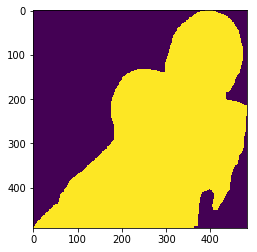

In [62]:
# First person
img = base64_2_mask(annotations_dict['objects'][0]['bitmap']['data']).astype(np.uint8)
plt.imshow(img)
plt.show()

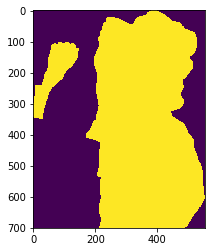

In [63]:
# Second person
img = base64_2_mask(annotations_dict['objects'][1]['bitmap']['data']).astype(np.uint8)
plt.imshow(img)
plt.show()

## 3. Extract Bounding Box Coordinates

We want arrays for each of $x_{min}$, $x_{max}$, $y_{min}$ and $y_{max}$.

In [74]:
x_mins = []
x_maxs = []
y_mins = []
y_maxs = []

# Note: mask/image origins are the top-left corners
img_width = annotations_dict['size']['width']
img_height = annotations_dict['size']['height']

for person in annotations_dict['objects']:
    mask_origin = person['bitmap']['origin']
    mask = base64_2_mask(person['bitmap']['data']).astype(np.uint8)
    mask_height = mask.shape[0]
    mask_width = mask.shape[1]
    
    # Get bounding box coords
    x_min = mask_origin[0]
    x_max = mask_origin[0] + mask_width
    y_min = mask_origin[1]
    y_max = mask_origin[1] + mask_height
    
    x_mins.append(x_min)
    x_maxs.append(x_max)
    y_mins.append(y_min)
    y_maxs.append(y_max)

In [75]:
print(x_mins)
print(x_maxs)
print(y_mins)
print(y_maxs)

[93, 358]
[576, 912]
[309, 99]
[800, 800]
